In [1]:
# MA Cross Backtesting on 1H BTC with following trade costs and timeframes
# - Slippage is 0.5BPS
# - Taker fee is 0.04%
# - Initial capital is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df = yf.download('BTC-USD', interval='1h', period='23mo')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-02 10:00:00+00:00,63045.832031,63501.312500,63045.832031,63187.867188,63187.867188,0
2021-11-02 11:00:00+00:00,63209.976562,63373.210938,63010.585938,63010.585938,63010.585938,0
2021-11-02 12:00:00+00:00,62965.082031,63297.093750,62965.082031,63079.828125,63079.828125,0
2021-11-02 13:00:00+00:00,63073.308594,63483.417969,63073.308594,63442.375000,63442.375000,0
2021-11-02 14:00:00+00:00,63445.765625,63798.214844,63187.011719,63375.765625,63375.765625,408469504
...,...,...,...,...,...,...
2023-10-02 06:00:00+00:00,27987.726562,28091.369141,27979.820312,28091.238281,28091.238281,173773824
2023-10-02 07:00:00+00:00,28110.933594,28402.677734,28110.933594,28291.509766,28291.509766,882821120
2023-10-02 08:00:00+00:00,28311.095703,28488.744141,28266.710938,28304.496094,28304.496094,1075058688


<Axes: xlabel='Datetime'>

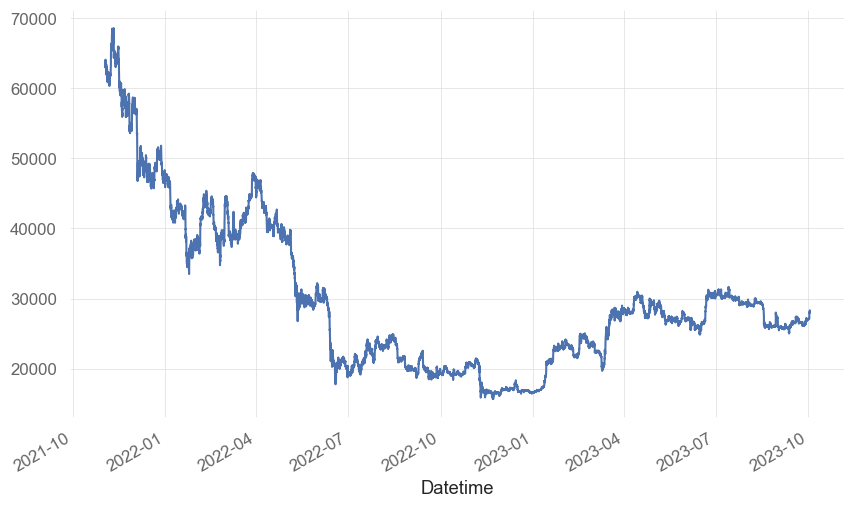

In [4]:
df['Close'].plot()

In [5]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [6]:
df['Signal'].value_counts()

Signal
 0    16327
 1      209
-1      208
Name: count, dtype: int64

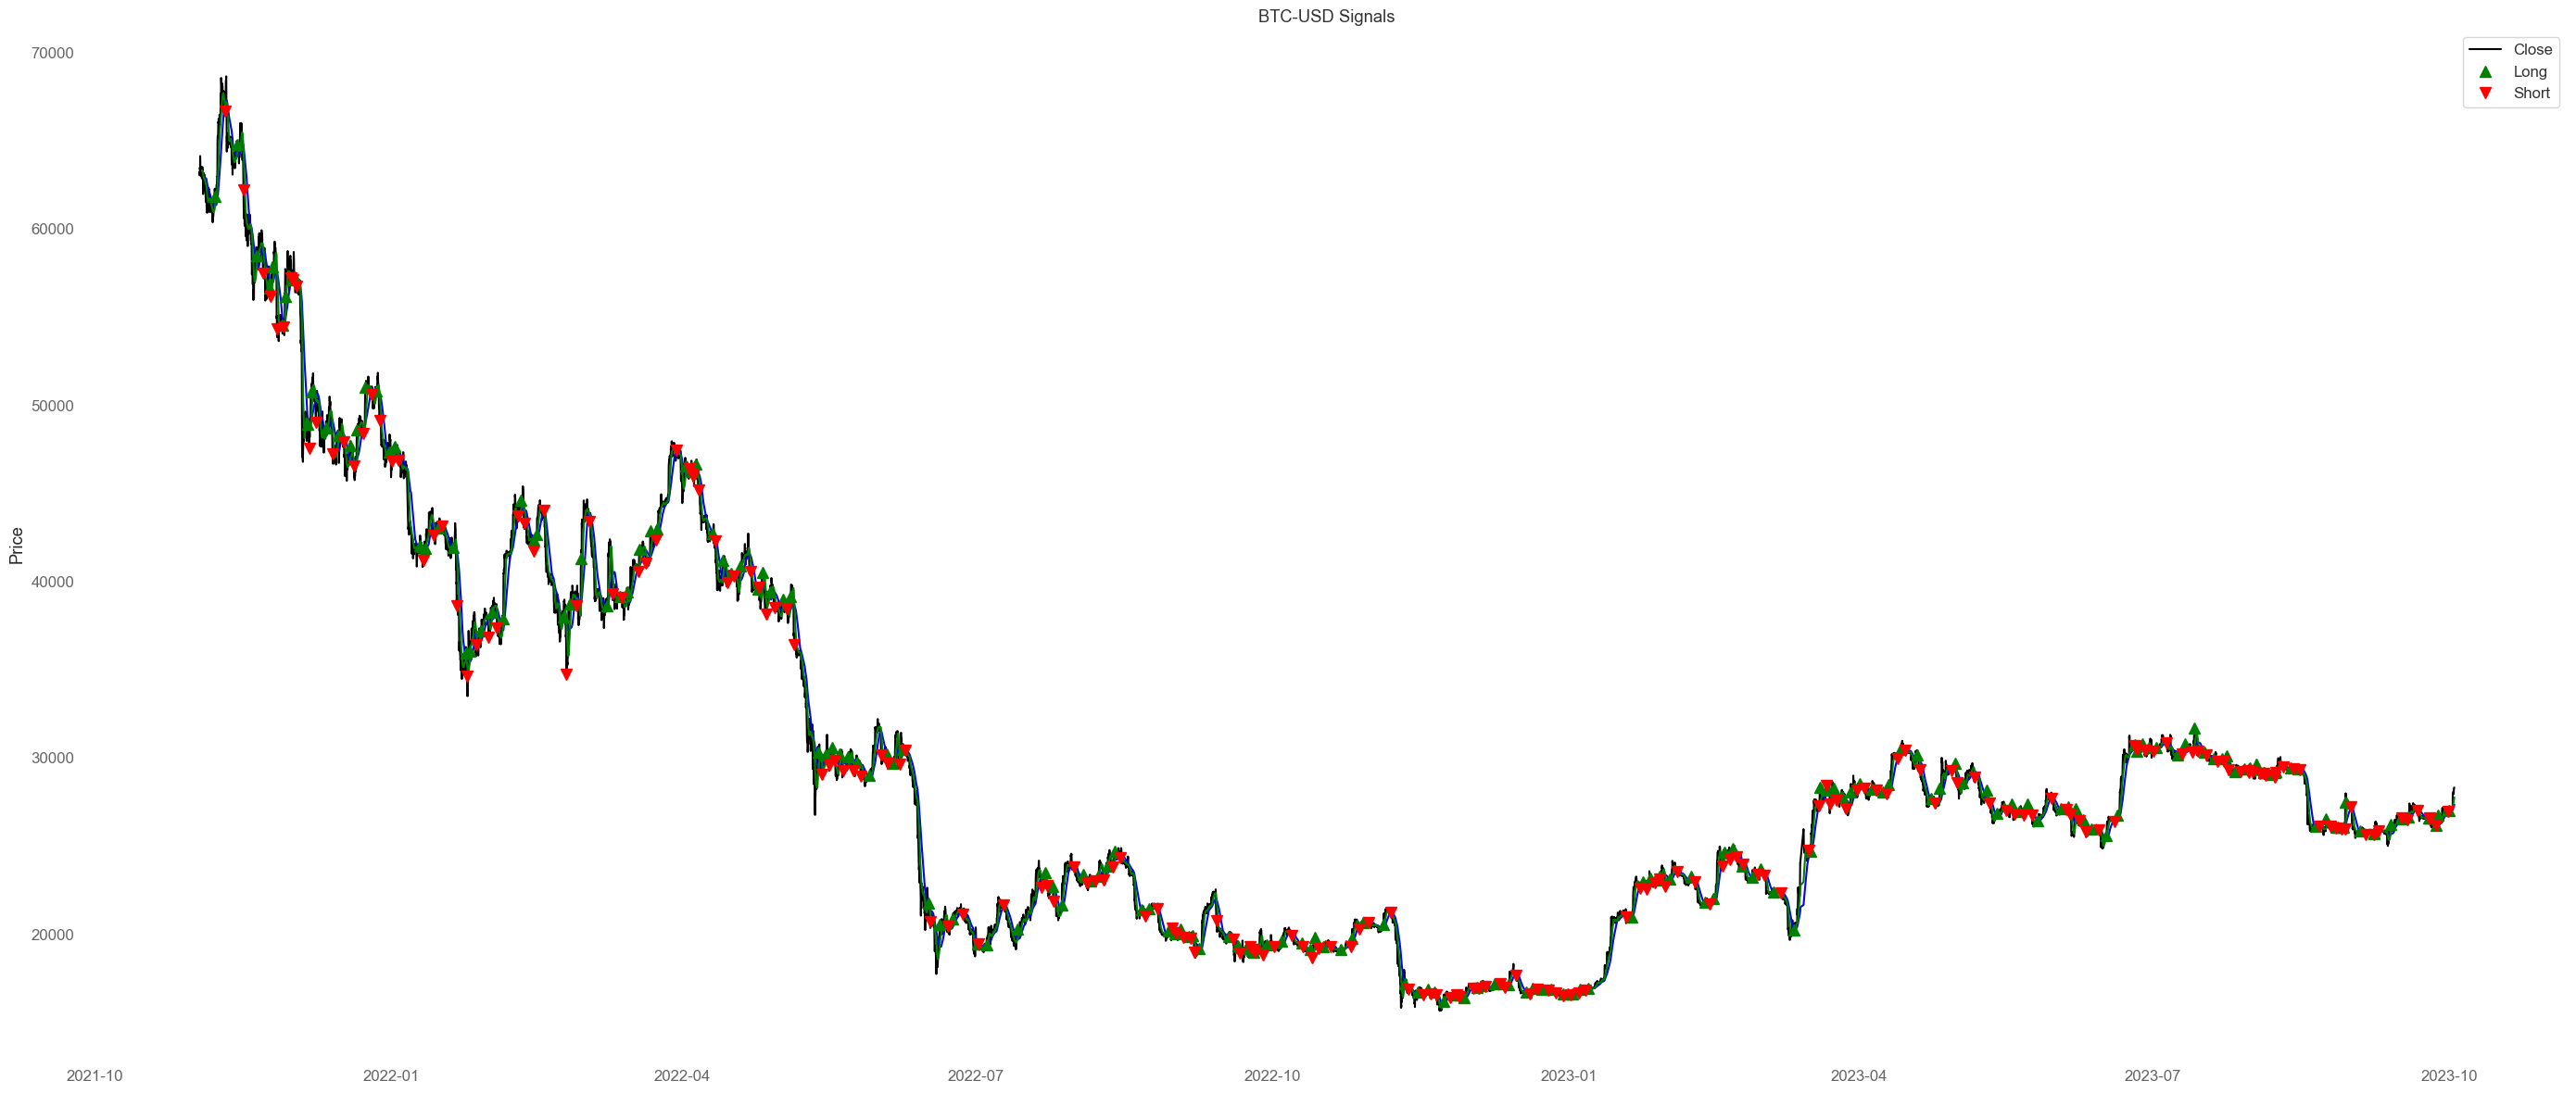

In [7]:
plot_df = df["2021-01-01":]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [8]:
# Position tracking with slippage

slippage_bps     = 0.5 / 10000 # 0.5BPS
position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close'] * (1 - slippage_bps) if position == 1 else row['Close'] * (1 + slippage_bps)
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 + slippage_bps)
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 - slippage_bps)
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [9]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.04    # 0.04% commission fee per trade
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [10]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2021-11-07 07:00:00+00:00,2021-11-07 08:00:00+00:00,61815.571093,61745.092279,-0.114015,-0.114015,-22.882932,9977.117068,NaN
2021-11-10 09:00:00+00:00,2021-11-10 10:00:00+00:00,66649.378302,66782.776472,0.200149,0.086134,39.858415,10016.975482,0.003995
2021-11-14 01:00:00+00:00,2021-11-14 02:00:00+00:00,64763.472387,64654.388213,-0.168435,-0.082300,-33.824265,9983.151217,-0.003377
2021-11-16 01:00:00+00:00,2021-11-16 02:00:00+00:00,62190.702809,61670.966207,-0.835714,-0.918015,-166.941112,9816.210105,-0.016722
2021-11-20 05:00:00+00:00,2021-11-20 06:00:00+00:00,58474.060276,58691.069206,0.371120,-0.546895,72.781308,9888.991413,0.007414
...,...,...,...,...,...,...,...,...
2023-09-26 20:00:00+00:00,2023-09-26 21:00:00+00:00,26159.366497,26155.344511,-0.015375,-4.334527,-2.808220,8898.083680,-0.000315
2023-09-26 21:00:00+00:00,2023-09-26 22:00:00+00:00,26155.344511,26153.010710,-0.008923,-4.343450,-1.659109,8896.424571,-0.000186
2023-09-27 11:00:00+00:00,2023-09-27 12:00:00+00:00,26727.572640,26694.696448,-0.123005,-4.466454,-21.957226,8874.467345,-0.002468


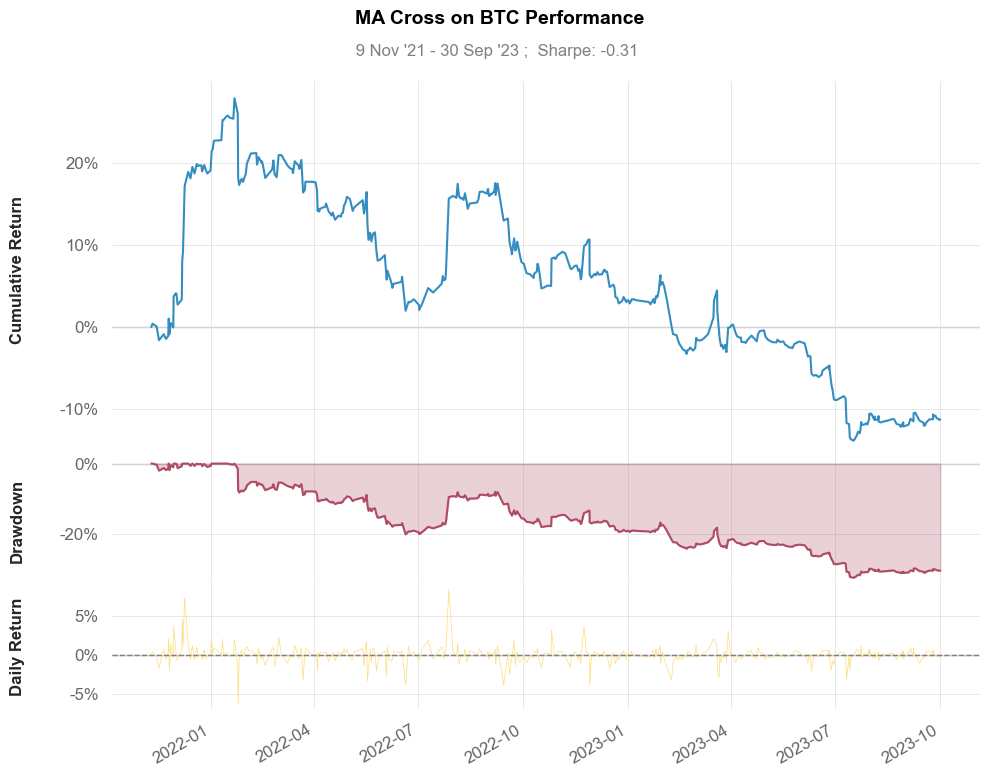

In [11]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC Performance', show=True);

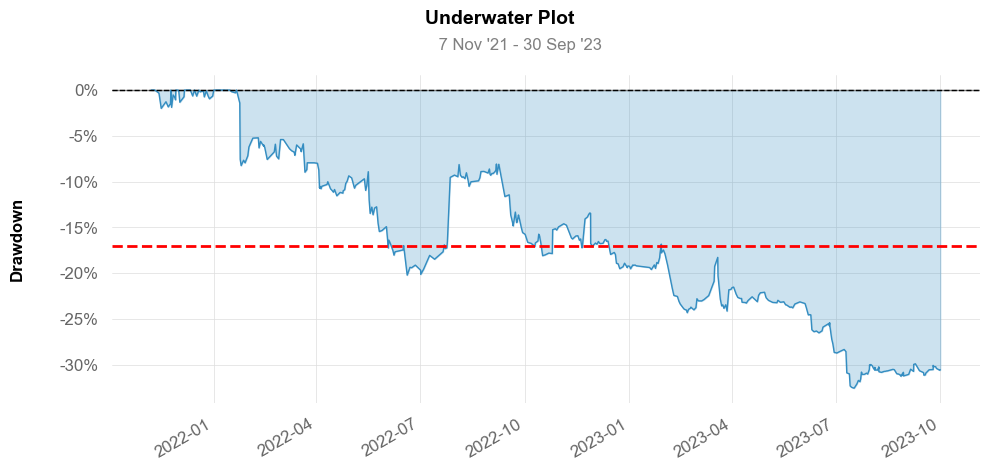

In [12]:
qs.plots.drawdown(position_df['Account Change'])

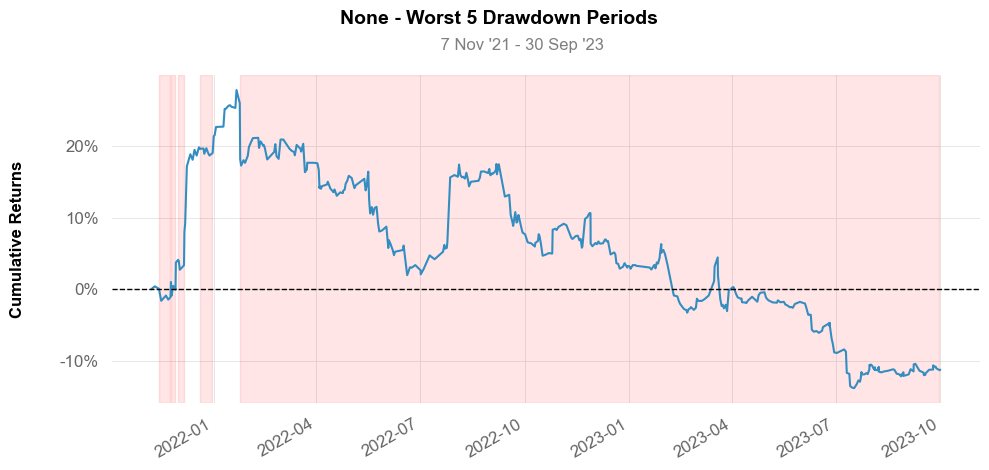

In [13]:
qs.plots.drawdowns_periods(position_df['Account Change'])

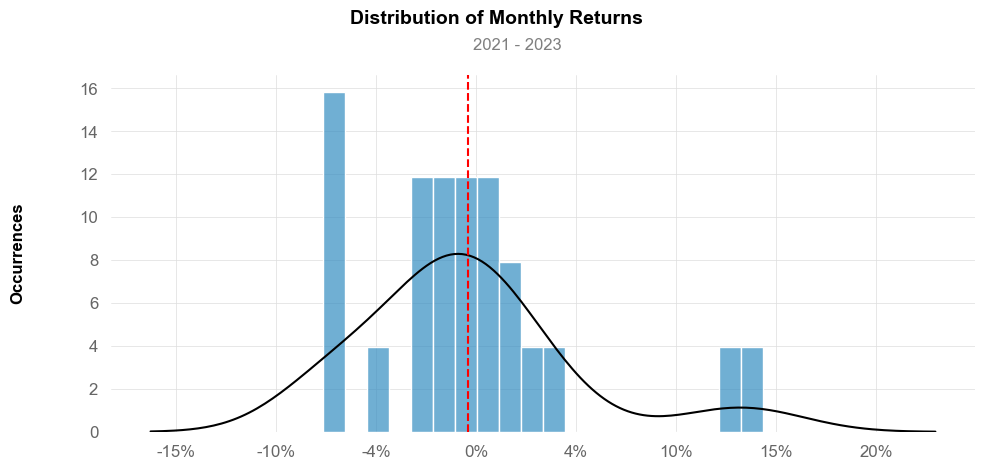

In [14]:
qs.plots.histogram(position_df['Account Change'])

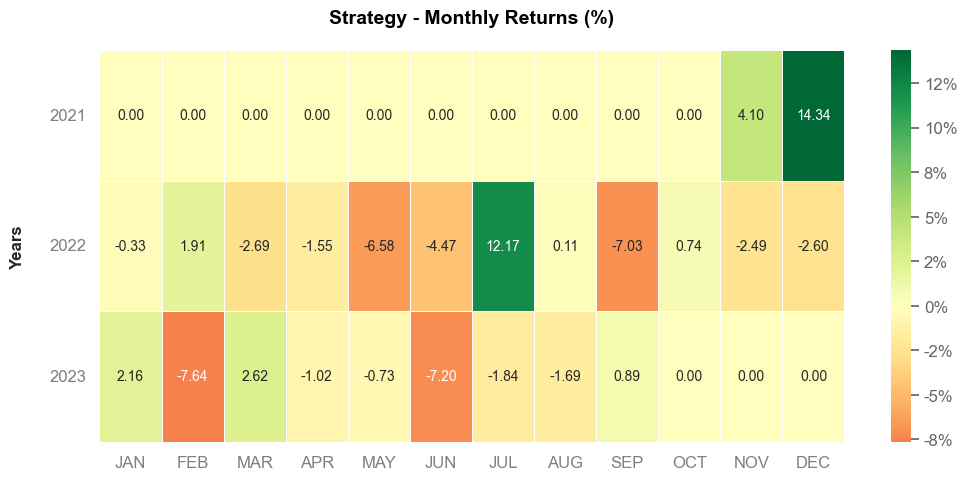

In [15]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [16]:
qs.stats.sharpe(position_df['Account Change'])

-0.3094838849333618

<Axes: xlabel='Entry Time'>

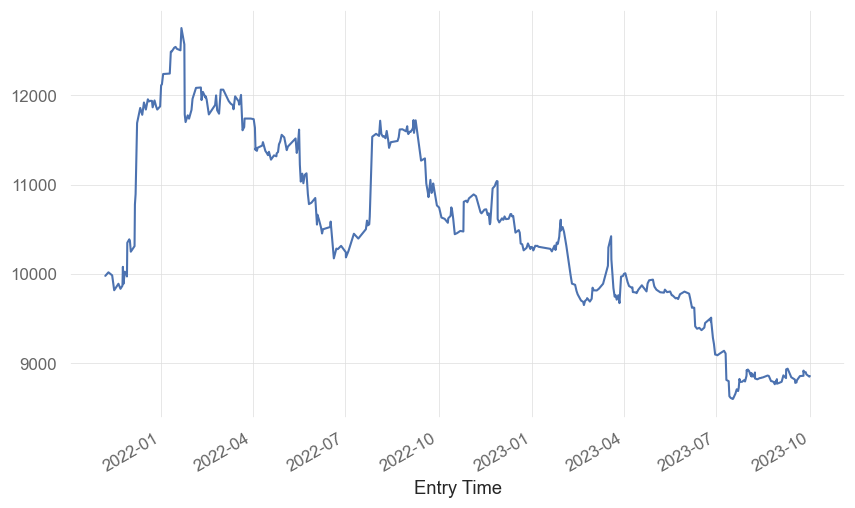

In [20]:
position_df["Account History"].plot()